# Segmentación de la señal para calcular biomarcadores de antisácadas

In [1]:
%matplotlib inline

import bsp.core
from bsp.core import load_study
from matplotlib import pyplot as plt
import numpy as np

plt.rcParams['figure.figsize'] = [14, 8]


study = load_study("data/20240420-rbg-antisaccade.bsp")
antisacade = study[1]

In [2]:
print(study)
print(study.json)

Study recorded at 2024-04-20 12:21:11 with 3 tests
{'version': '1.0', 'recorded_at': 1713608471.792647, 'tests': [{'test_type': 'HorizontalCalibration', 'angle': 30, 'fs': 1000, 'length': 20000, 'hor_annotations': [], 'ver_annotations': []}, {'test_type': 'HorizontalAntisaccadic', 'angle': 30, 'fs': 1000, 'length': 40000, 'hor_annotations': [], 'ver_annotations': []}, {'test_type': 'HorizontalCalibration', 'angle': 30, 'fs': 1000, 'length': 20000, 'hor_annotations': [], 'ver_annotations': []}], 'hor_calibration': 0.07837202458679882, 'hor_calibration_diff': 1.0345377263836386, 'ver_calibration': 1.0, 'ver_calibration_diff': 1.0, 'protocol': 'saccadic'}


## Investigando direfencias de impulses y saccades
- Impulses: Utiliza KMeans --> separa movimientos rápidos de los lentos
- Saccades: Identifica las sácadas a partir de la velocidad y teniendo en cuenta la amplitud

In [3]:
from bsp.core import impulses
c = 0
for start, end in impulses(antisacade.hor_channel):
    #print("Impulso:", start/1000, end/1000) #segundos
    #print("Len(impulso): " , len(antisacade.hor_channel[start:end]))
    #print(antisacade.hor_channel[start:end])
    c += 1
print("Total impulsos: ", c)

Total impulsos:  40


In [4]:
from bsp.core.saccades import saccades
total_sacadas = 0
for onset, offset in saccades(antisacade.hor_channel, antisacade.angle, 0.2):
    total_sacadas += 1
    #print("Saccade onset:", onset, "Saccade offset:", offset)
print("Total sacadas" , total_sacadas)

Total sacadas 18


In [5]:
from bsp.core.differentiation import differentiate
from bsp.core.impulses import impulses

import numpy as np
from enum import Enum
from numpy import ndarray

def antisaccades(channel: np.ndarray, stimuli: np.ndarray) -> list[tuple[int, int]]:
    list = []
    samples_to_remove = 100
    stimuli = stimuli.copy()[:-samples_to_remove]
    amplitude_stimuli = abs(min(stimuli) - max(stimuli))
    c = 0
            
    for start, end in impulses(channel):
        amplitude_channel = max(abs(max(channel[start:end])), abs(min(channel[start:end]))) - min(abs(max(channel[start:end])), abs(min(channel[start:end])))
            
        if amplitude_channel > (amplitude_stimuli-1)/2:
            list.append((start, end))
            c += 1
    print(c)
    return list


17
[(3693, 3787), (5443, 5522), (7336, 7429), (9168, 9248), (10836, 10930), (12652, 12723), (14378, 14451), (16229, 16292), (17879, 17981), (21241, 21333), (23007, 23087), (24762, 24853), (26597, 26688), (28419, 28499), (31850, 31940), (33653, 33710), (35336, 35420)]
17


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


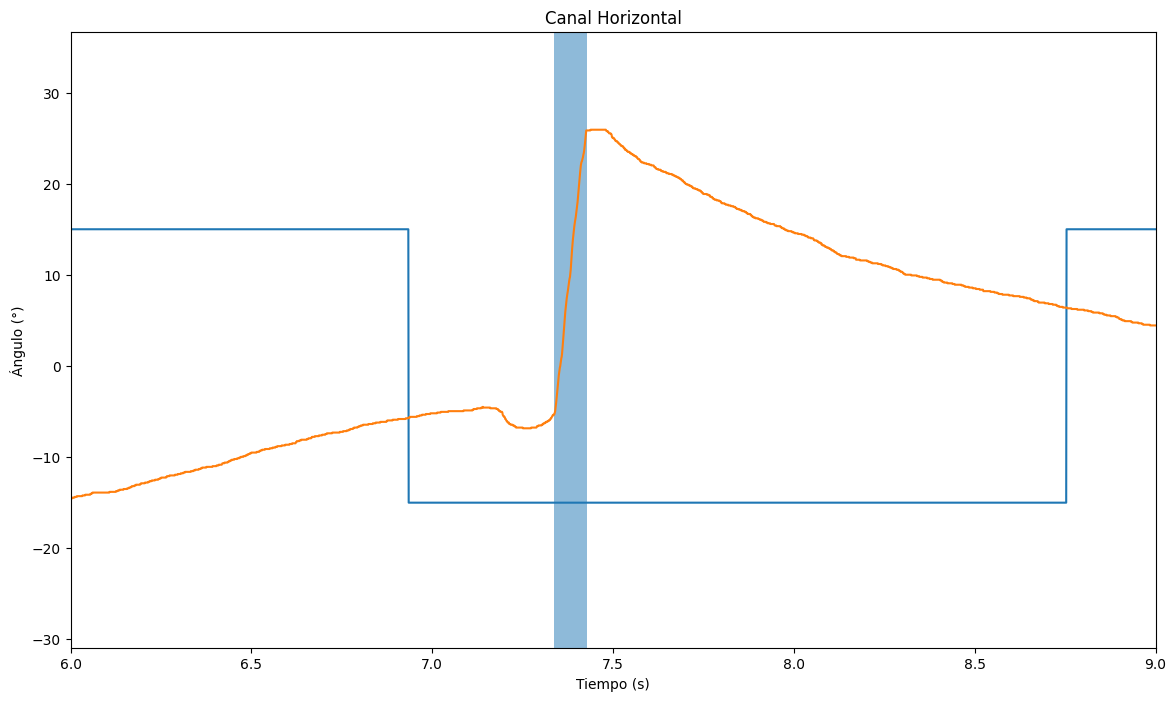

In [6]:
#from bsp.core.biomarkers import antisaccades

resultados = antisaccades(antisacade.hor_channel, antisacade.hor_stimuli)
print(resultados)

time = np.arange(len(antisacade.hor_stimuli)) / 1000.0  # segundos

plt.title("Canal Horizontal")
for start, end in antisaccades(antisacade.hor_channel, antisacade.hor_stimuli):
    plt.axvspan((start)/1000, (end)/1000, alpha=0.5)
plt.plot(time[0:37000], antisacade.hor_stimuli[0:37000])
plt.plot(time[0:37000], antisacade.hor_channel[0:37000])
plt.ylabel("Ángulo (°)");
plt.xlabel("Tiempo (s)")
plt.xlim(6,9)
plt.savefig("Antisácada.eps", format="eps")


(6.0, 8.0)

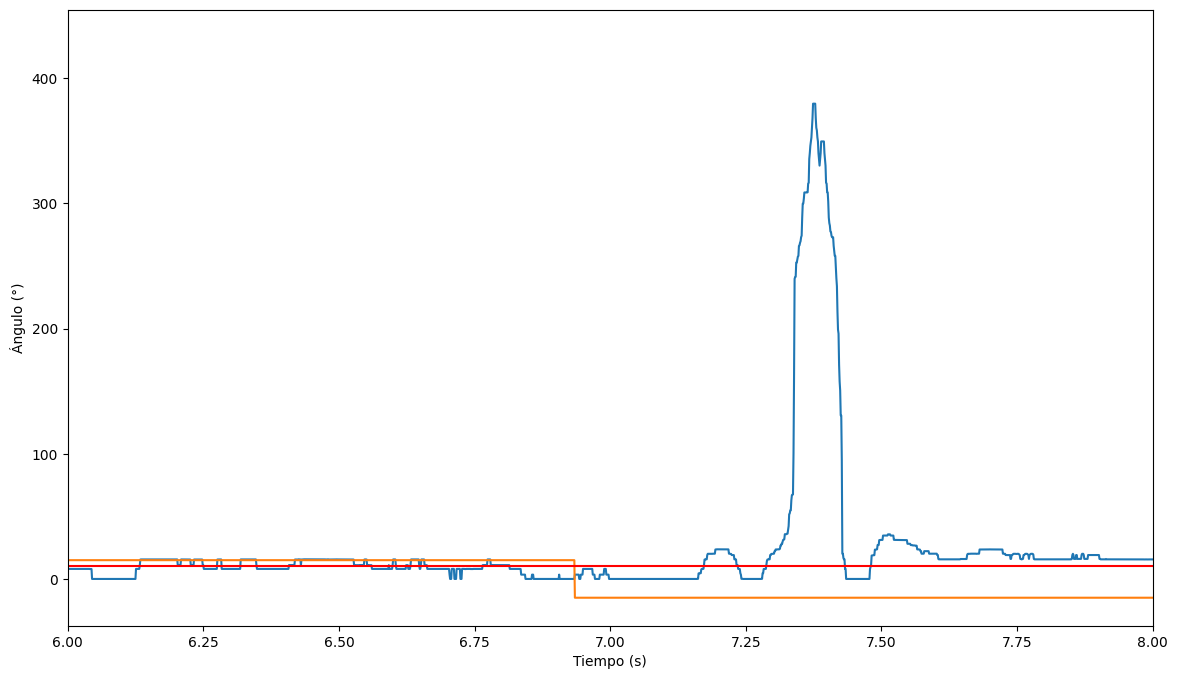

In [7]:
from scipy.signal import medfilt

plt.plot(time[0:37000], abs(medfilt(differentiate(antisacade.hor_channel[0:37000]), 71)))
plt.plot(time[0:37000], antisacade.hor_stimuli[0:37000])
plt.ylabel("Ángulo (°)");
plt.xlabel("Tiempo (s)")
plt.axhline(10, color='red')
plt.savefig("Umbra_Microsacada.eps", format="eps")
plt.xlim(6, 8)

## Detección sácadas

In [8]:
from bsp.core.differentiation import differentiate
from scipy.signal import medfilt

def saccades(channel: np.ndarray, changes_stimuli: list[int], antisaccades: list[tuple[int, int]]) -> list[tuple[int, int]]:
    list = []
    UMBRAL_VELOCIDAD_MICROSACADA = 10
    DURACION_MINIMA_MICROSACADA = 10
    DISTANCIA_MINIMA_DEL_ESTIMULO = 200
    velocities_abs = abs(denoise_01(differentiate(hor_channel_filter)))

    def identify_saccade(index: int) -> tuple[int, int] | None:
        left = index
        while left > 0 and velocities_abs[left - 1] >= UMBRAL_VELOCIDAD_MICROSACADA:
            left -= 1
        right = index
        while right < len(channel) - 1 and velocities_abs[right + 1] >= UMBRAL_VELOCIDAD_MICROSACADA:
            right += 1
        if right - left >= DURACION_MINIMA_MICROSACADA:
            return left, right
        return None

    for change_index in changes_stimuli:
        # Encontrar la próxima antisácada después de este cambio en el estímulo
        next_antisaccade_start = None
        for antisaccade_start, antisaccade_end in antisaccades:
            if antisaccade_start > change_index:
                next_antisaccade_start = antisaccade_start
                break
        in_saccade = False
        if next_antisaccade_start is not None:
            for idx in range(change_index, next_antisaccade_start):
                #print("change_index", change_index)
                if next_antisaccade_start - idx > 1000: # El impulso no corresponde con la antisácada
                    break
                
                if velocities_abs[idx] > UMBRAL_VELOCIDAD_MICROSACADA:
                    saccade = identify_saccade(idx)
                    if saccade:
                        list.append(saccade) 
                    
                    #if in_saccade == False:
                     #   start = idx
                     #   in_saccade = True
                        #print("next_antisaccade_start", next_antisaccade_start)
                        #print("saccade_start: ", start)
                    #if velocities_abs[idx + 1] < UMBRAL_VELOCIDAD_MICROSACADA:
                    #    end = idx
                     #   in_saccade = False
                        #print("next_antisaccade_start", next_antisaccade_start)
                        #print("Velocidad: ",velocities_abs[idx])
                        #print("Duracion: ", (end-start))
                        #print("Distacia con el estimulo: ", (start - change_index))
                        #print("***************")
                       # if (end - start) > DURACION_MINIMA_MICROSACADA and (start - change_index) > DISTANCIA_MINIMA_DEL_ESTIMULO:
                            #print("change_index", change_index)
                            #print("saccade_start: ", start)
                            #print("saccade_end: ", end)
                            #print("Velocidad: ",velocities_abs[idx])
                            #print("Duracion: ", (end-start))
                            #print("Distacion con el estimulo: ", (start - change_index))
                            #print("---------------------")
                          #  list.append((start, end))  
    return list

In [9]:
def detect_changes(stimuli: np.ndarray) -> list[int]:
    change_indices = []
    for i in range(1, len(stimuli)):
        if stimuli[i] != stimuli[i - 1]:
            change_indices.append(i)
    return change_indices

(0.0, 37.0)

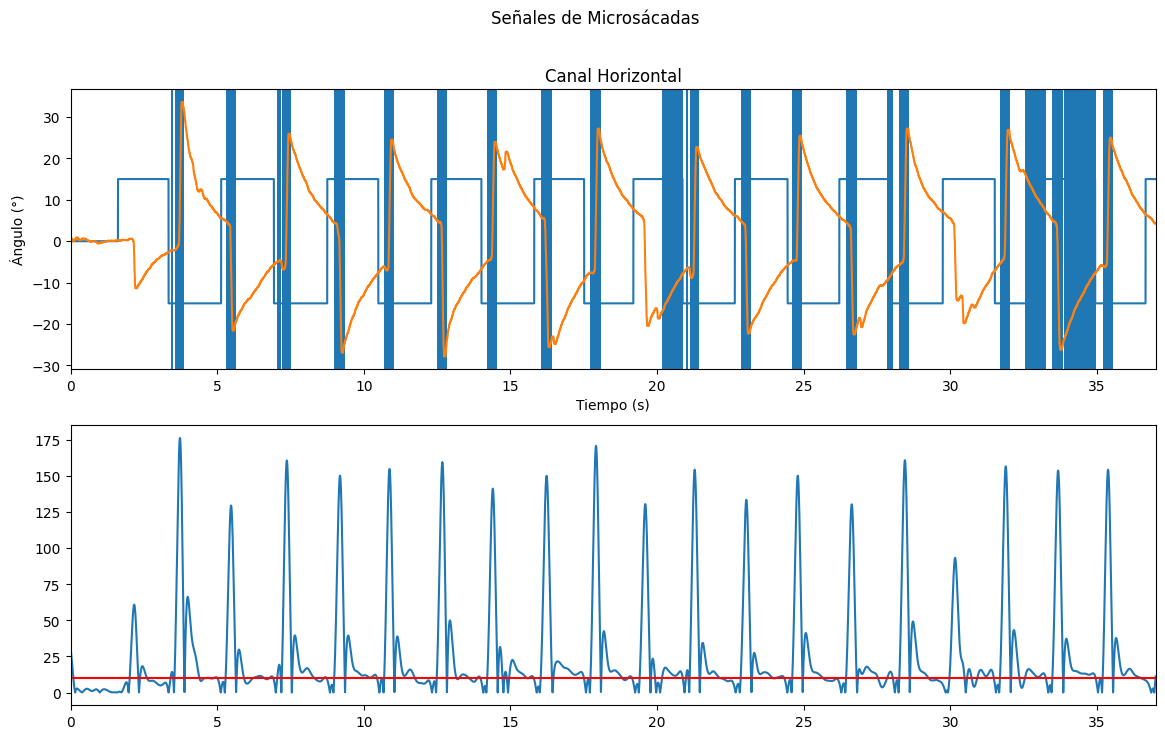

In [10]:
from scipy import signal
def denoise_35(value: np.ndarray) -> np.ndarray:
    # Hacemos un filtrado agresivo ya que lo que nos interesa es la forma de onda 
    # en general de la señal para identificar el desfase
    b, a = signal.butter(3, 0.035)
    y = signal.filtfilt(b, a, value)
    return y

def denoise_01(value: np.ndarray) -> np.ndarray:
    # Hacemos un filtrado agresivo ya que lo que nos interesa es la forma de onda 
    # en general de la señal para identificar el desfase
    b, a = signal.butter(3, 0.005)
    y = signal.filtfilt(b, a, value)
    return y
    
hor_channel_filter = denoise_35(antisacade.hor_channel_raw * study.hor_calibration)
sacadas = saccades(hor_channel_filter, detect_changes(antisacade.hor_stimuli), resultados)
#print(sacadas)
#print(len(sacadas))

plt.suptitle("Señales de Microsácadas")

plt.subplot(211)
plt.title("Canal Horizontal")
for start, end in sacadas:
#for start, end in saccades(antisacade.hor_channel, antisacade.angle, 0.2):
    plt.axvspan((start)/1000, (end)/1000, alpha=1)
plt.plot(time, antisacade.hor_stimuli)
plt.plot(time, antisacade.hor_channel)
plt.ylabel("Ángulo (°)");
plt.xlabel("Tiempo (s)")
plt.xlim(0, 37)  # Limitar el eje x
plt.savefig("Detección_Microsácadas.eps", format="eps")

plt.subplot(212)
velocities_abs = abs(denoise_01(differentiate(hor_channel_filter)))
plt.plot(time, velocities_abs)
plt.axhline(10, color='red')
plt.xlim(0, 37)


(20.0, 22.0)

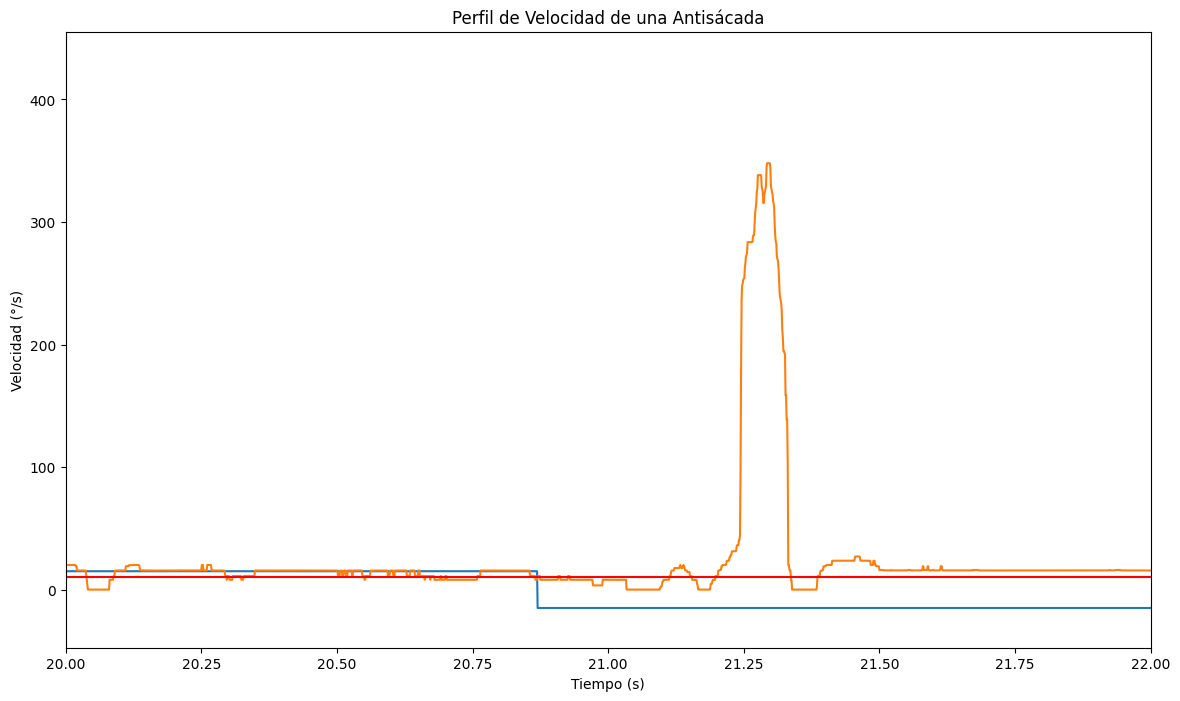

In [11]:
plt.title("Perfil de Velocidad de una Antisácada")
plt.plot(time, antisacade.hor_stimuli)
plt.plot(time, abs(medfilt(differentiate(antisacade.hor_channel), 71)))
plt.xlabel("Tiempo (s)")
plt.ylabel("Velocidad (°/s)");
plt.axhline(10, color='red')
plt.xlim(20, 22)

In [12]:
def detect_saccades(channel: np.ndarray, change_indices: list[int], antisaccades: list[tuple[int, int]]) -> list[tuple[int, int]]:
    saccades = []
    window = 40  # Tamaño de la ventana para determinar la dirección del cambio

    for change_index in change_indices:
        # Encontrar la próxima antisácada después de este cambio en el estímulo
        next_antisaccade_start = None
        for antisaccade_start, antisaccade_end in antisaccades:
            if antisaccade_start > change_index:
                next_antisaccade_start = antisaccade_start
                break

        if next_antisaccade_start is not None: # Buscar por velocidad
            # Buscar el cambio en el canal ocular entre el cambio de estímulo y la próxima antisácada
            for idx in range(change_index, next_antisaccade_start):
                if next_antisaccade_start - idx > 1000: # El impulso no corresponde con la antisácada
                    break
                if idx >= window and idx < len(channel):
                    pre_change_direction = np.sign(channel[idx] - channel[idx - window])
                    post_change_direction = np.sign(channel[idx + window] - channel[idx])
                    if pre_change_direction != post_change_direction:
                        print("idx: ", idx)
                        #print("next_antisaccade_start: ", next_antisaccade_start)
                        # Buscar el punto donde la señal vuelve a la dirección pre-cambio
                        for j in range(idx, next_antisaccade_start):
                            if np.sign(channel[j] - channel[idx]) == pre_change_direction:
                                saccades.append((idx, j))
                                break

    return saccades


In [13]:
sacadas = saccades(antisacade.hor_channel, detect_changes(antisacade.hor_stimuli), resultados)
print(sacadas)

[(3411, 3499), (3411, 3499), (3411, 3499), (3411, 3499), (3411, 3499), (3411, 3499), (3411, 3499), (3411, 3499), (3411, 3499), (3411, 3499), (3411, 3499), (3411, 3499), (3411, 3499), (3411, 3499), (3411, 3499), (3411, 3499), (3411, 3499), (3411, 3499), (3411, 3499), (3411, 3499), (3411, 3499), (3411, 3499), (3411, 3499), (3411, 3499), (3411, 3499), (3411, 3499), (3411, 3499), (3411, 3499), (3411, 3499), (3411, 3499), (3411, 3499), (3411, 3499), (3411, 3499), (3411, 3499), (3411, 3499), (3411, 3499), (3411, 3499), (3411, 3499), (3411, 3499), (3411, 3499), (3411, 3499), (3411, 3499), (3411, 3499), (3411, 3499), (3411, 3499), (3411, 3499), (3411, 3499), (3411, 3499), (3411, 3499), (3411, 3499), (3411, 3499), (3411, 3499), (3411, 3499), (3411, 3499), (3411, 3499), (3411, 3499), (3411, 3499), (3411, 3499), (3411, 3499), (3411, 3499), (3411, 3499), (3411, 3499), (3411, 3499), (3411, 3499), (3411, 3499), (3411, 3499), (3411, 3499), (3411, 3499), (3411, 3499), (3411, 3499), (3411, 3499), (3411

Text(0.5, 0, 'Tiempo (s)')

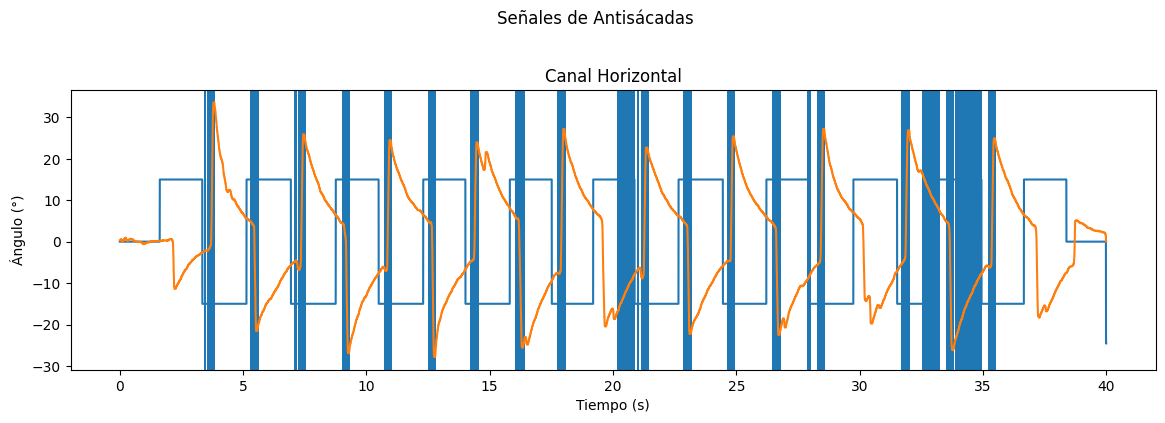

In [14]:
plt.suptitle("Señales de Antisácadas")

plt.subplot(211)
plt.title("Canal Horizontal")
for start, end in sacadas:
#for start, end in saccades(antisacade.hor_channel, antisacade.angle, 0.2):
    plt.axvspan((start)/1000, (end)/1000, alpha=0.5)
plt.plot(time, antisacade.hor_stimuli)
plt.plot(time, antisacade.hor_channel)
plt.ylabel("Ángulo (°)");
plt.xlabel("Tiempo (s)")
#plt.xlim(6, 8)  # Limitar el eje x de 0 a 5 segundos


## Dirección
| Celda 1 | Stimuli + | Stimuli - |
|---------|---------|---------|
| Channel + | Sácada Derecha | Antisácada Derecha |
| Channel - | Antisácada Izq | Sácada Izq |

In [15]:
class Direction(Enum):
    Left = "left"
    Right = "right"
    
def direction(channel: np.ndarray, stimuli: np.ndarray, start: int, end: int) -> Direction:
    if channel[end] > 0:
        if stimuli[end] > 0:
            # Sacada Derecha
            return Direction.Right
        elif stimuli[end] < 0:
            # Antisácada Derecha
            return Direction.Right
    elif channel[end] < 0:
        if stimuli[end] > 0:
            # Antisácada Izquierda
            return Direction.Left
        elif stimuli[end] < 0:
            # Sácada Izquierda
            return Direction.Left
        

In [16]:
direccion = direction(antisacade.hor_channel, antisacade.hor_stimuli, 3691, 5522)
print(direccion)

Direction.Left


## Latencia antisacádica
$$\text{Latencia antisacádica} = (X_{\text{inicio antisácada}} - X_{\text{inicio estímulo}}) \times \text{Intervalo de muestras}$$

In [17]:
def detect_changes(stimuli: np.ndarray) -> list[int]:
    change_indices = []
    for i in range(1, len(stimuli)):
        if stimuli[i] != stimuli[i - 1]:
            change_indices.append(i)
    return change_indices

# Ejemplo de uso
estimulo = np.array([0, 15, 15, -15, -15, -15, 15, 15, 15])
cambios = detect_changes(antisacade.hor_stimuli)
print("Cambios en los índices:", cambios)

Cambios en los índices: [1617, 3342, 5135, 6935, 8754, 10494, 12300, 14012, 15812, 17514, 19193, 20870, 22654, 24452, 26216, 27963, 29744, 31518, 33192, 34940, 36660, 38383, 39988]


In [18]:
movements = antisaccades(antisacade.hor_channel, antisacade.hor_stimuli)
print(movements)

17
[(3693, 3787), (5443, 5522), (7336, 7429), (9168, 9248), (10836, 10930), (12652, 12723), (14378, 14451), (16229, 16292), (17879, 17981), (21241, 21333), (23007, 23087), (24762, 24853), (26597, 26688), (28419, 28499), (31850, 31940), (33653, 33710), (35336, 35420)]


In [19]:
def antisaccade_latencies_biomarker(stimuli: np.ndarray, movements: list[tuple[int, int]]) -> list[float]:
    
    def detect_changes(stimuli: np.ndarray) -> list[int]:
        change_indices = []
        for i in range(1, len(stimuli)):
            if stimuli[i] != stimuli[i - 1]:
                change_indices.append(i)
        return change_indices
    
    latencies = []
    SAMPLES_INTERVAL = 1/1000
    stimuli_changes = detect_changes(stimuli)
    for start, end in movements:
        last_stimuli = max(change for change in stimuli_changes if change < start)
        latency = (start - last_stimuli) * SAMPLES_INTERVAL
        latencies.append(latency)
    return latencies
    

In [20]:
latencias = antisaccade_latencies_biomarker(antisacade.hor_stimuli, movements)
print(latencias)

[0.35100000000000003, 0.308, 0.401, 0.41400000000000003, 0.342, 0.352, 0.366, 0.417, 0.365, 0.371, 0.353, 0.31, 0.381, 0.456, 0.332, 0.461, 0.396]


In [21]:
def detect_changes(stimuli: np.ndarray) -> list[int]:
        change_indices = []
        for i in range(1, len(stimuli)):
            if stimuli[i] != stimuli[i - 1]:
                change_indices.append(i)
        return change_indices

In [22]:
stimuli_changes = detect_changes(antisacade.hor_stimuli)
print(stimuli_changes)

[1617, 3342, 5135, 6935, 8754, 10494, 12300, 14012, 15812, 17514, 19193, 20870, 22654, 24452, 26216, 27963, 29744, 31518, 33192, 34940, 36660, 38383, 39988]


## Duración
$$\text{Duración} = (X_{\text{fin antisácada}} - X_{\text{inicio antisácada}}) \times \text{Intervalo de muestras}$$

In [23]:
def antisaccade_durations_biomarker(movements: list[tuple[int, int]]) -> list[float]:
    durations = []
    samples_interval = 1/1000
    for start, end in movements:
        duration = (end - start) * samples_interval
        durations.append(duration)
    return durations

In [24]:
durations = antisaccade_durations_biomarker(movements)
print(durations)

[0.094, 0.079, 0.093, 0.08, 0.094, 0.07100000000000001, 0.073, 0.063, 0.10200000000000001, 0.092, 0.08, 0.091, 0.091, 0.08, 0.09, 0.057, 0.084]


## Velocidad máxima
No aplico filtro a la velocidad , debería?

In [25]:
from bsp.core.differentiation import differentiate

def antisaccade_velocities_biomarker(channel: np.ndarray, movements: list[tuple[int, int]]) -> list[float]:
    velocities = []
    for start, end in movements:
        velocidad_max = max(abs(differentiate(channel[start:end])))
        velocities.append(velocidad_max)
    return velocities

In [26]:
velocities = antisaccade_velocities_biomarker(antisacade.hor_channel, movements)
print(velocities)

[682.4516809162653, 586.6943372713102, 600.7606570074146, 598.4162947144172, 543.0628295637604, 736.8616691002478, 596.1022995753907, 513.1020523729302, 585.7498595764587, 624.2512345036149, 579.4933981550879, 555.6984999981979, 536.5926643258949, 527.8693156920391, 567.0860908526085, 593.8494229557539, 528.6759818906272]


## Location in memory
$$\text{Precisión de la localización del estímulo en memoria} = \frac{\text{Amplitud del estímulo}-\text{Amplitud de la antisácada}}{\text{Amplitud del estímulo}}$$

$$\text{Amplitud de la antisácada} = \left| Y_{\text{fin antisácada}} - Y_{\text{inicio antisácada}} \right|$$

In [27]:
def antisaccade_location_memory_biomarker(channel: np.ndarray, stimuli: np.ndarray, antisaccades_movements:list[tuple[int, int]]) -> list[float]:
    accuracy_locations_memory = []
    amplitude_stimuli = abs(min(stimuli) - max(stimuli))

    for start, end in antisaccades_movements:
        amplitude_channel = max(abs(max(channel[start:end])), abs(min(channel[start:end]))) - min(abs(max(channel[start:end])), abs(min(channel[start:end])))
        location_memory = (amplitude_stimuli - amplitude_channel)/amplitude_stimuli
        accuracy_locations_memory.append(location_memory)
    return accuracy_locations_memory

In [28]:
loc = antisaccade_location_memory_biomarker(antisacade.hor_channel, antisacade.hor_stimuli, movements)
print(loc)

[0.16930428, 0.5514274, 0.48219022, 0.32868114, 0.5534808, 0.43459022, 0.4425844, 0.5425527, 0.48615095, 0.6247713, 0.5613288, 0.47228876, 0.5435062, 0.4663479, 0.4663479, 0.48805806, 0.59704715]


## Inhibición de la respuesta
$$\text{Inhibición de la respuesta} = \frac{\text{Total sácadas inapropiadas}}{\text{Total antisácadas}}$$

In [29]:
def antisaccade_response_inhibition_biomarker(saccades_movements: list[tuple[int, int]], antisaccades_movements: list[tuple[int, int]]) -> float:
    print(len(saccades_movements))
    print(len(antisaccades_movements))
    return len(saccades_movements)/len(antisaccades_movements)

In [30]:
inhibition_biomarker = antisaccade_response_inhibition_biomarker(sacadas, movements)
print(inhibition_biomarker)

3093
17
181.94117647058823


## Latencia Antisacádica Correctora 
$$\text{Latencia antisacádica correctora} = (X_{\text{inicio antisácada}} - X_{\text{fin microsácada}}) \times \text{Intervalo de muestras}$$

In [34]:
def antisaccade_correction_latencies_biomarker(saccades_movements: list[tuple[int, int]], antisaccades_movements: list[tuple[int, int]]) -> list[float]:
    SAMPLES_INTERVAL = 1/1000
    correction_latencies = []
    
    for start_microsaccade, end_microsaccade in saccades_movements:
        next_antisaccade_start = None
        for start_antisaccade, end_antisaccade in antisaccades_movements:
            if start_antisaccade > end_microsaccade:
                #print("start_antisaccade", start_antisaccade)
                #print("end_microsaccade",end_microsaccade)
                #print("diferencia", (start_antisaccade - end_microsaccade))
                #print("---------------------")
                next_antisaccade_start = start_antisaccade
                break
        if next_antisaccade_start is not None:
            correction_latencies.append((start_antisaccade - end_microsaccade)*SAMPLES_INTERVAL)
    return correction_latencies

In [36]:
correction_latencies = antisaccade_correction_latencies_biomarker(sacadas, movements)
#print(correction_latencies)

# Probando calibración nueva

## Configuración del ambiente

In [37]:
from matplotlib import pyplot as plt

plt.rcParams['figure.figsize'] = [14, 8]

## Carga del Estudio y el Test (Prueba)

In [38]:
from bsp.core import load_study

study = load_study("data/20240420-rbg-antisaccade.bsp")

antisaccadic = study[1]

## Funciones y Clases Utilitarias

In [40]:
import numpy as np
from numpy import ndarray, single
from scipy import signal
from enum import Enum
from bsp.core.differentiation import differentiate
from typing import Iterator
from bsp.core import calibration

class Direction(Enum):
    Same = "same"
    Left = "left"
    Right = "right"


class Size(Enum):
    Invalid = "inv"
    Small = "small"
    Large = "large"

def scale_channel(value: np.ndarray, angle: float) -> np.ndarray:
    # Llevar el estímulo al angulo indicado
    scale = 0.07837202458679882 # Escala usando calibration.py
    print("scale", scale)
    return value.astype(single) * scale

def scale_stimuli(value: np.ndarray, angle: float) -> np.ndarray:
    min_value = min(value)
    max_value = max(value)

    amplitude_raw = max_value - min_value
    scale = angle / amplitude_raw
    print("sacale stimuli: ",  scale)
    return  value * scale

def center_signal(value: np.ndarray) -> np.ndarray:
    return value - value.mean()

def denoise_35(channel: np.ndarray) -> np.ndarray:
    # Hacemos un filtrado agresivo ya que lo que nos interesa es la forma de onda 
    # en general de la señal para identificar el desfase
    b, a = signal.butter(3, 0.035)
    y = signal.filtfilt(b, a, channel)
    return y

def impulses(
    channel: np.ndarray, 
    peaks: list[int], 
    velocity_threshold: float = 10.0,  # Grados por segundo
    duration_threshold: float = 10     # Milisegundos o muestras
) -> Iterator[tuple[int, int]]:
    for peak in peaks:
        onset = peak
        while onset > 0 and channel[onset - 1] >= velocity_threshold:
            onset -= 1
            
        offset = peak
        while offset < len(channel) - 1 and channel[offset + 1] >= velocity_threshold:
            offset += 1

        if offset - onset >= duration_threshold:
            yield onset, offset

def clasify_impulses(
    channel: np.ndarray, 
    impulses: tuple[int, int]
) -> Iterator[tuple[int, int, Direction, Size, int, float]]:
    # Onset, Offset, Direction, Size, Duration, Amplitude
    already_yielded = set()
    
    for onset, offset in impulses:
        duration = offset - onset
        
        onset_angle = channel[onset]
        offset_angle = channel[offset]

        amplitude = abs(offset_angle - onset_angle)
        if onset_angle < offset_angle:
            direction = Direction.Right
        elif onset_angle > offset_angle:
            direction = Direction.Left
        else:
            direction = Direction.Same

        if amplitude < 1.0:
            size = Size.Invalid
        elif amplitude < 5.0:
            size = Size.Small
        else:
            size = Size.Large

        if (onset, offset) not in already_yielded:
            already_yielded.add((onset, offset))
        else:
            continue

        yield onset, offset, direction, size, duration, amplitude


## Procedimiento:
- Se ha utilizado la calibración del profe para el escalado del estimulo y para la calibración del software para el escalado de la horizontal
- Despues de quitar ruido en la horizontal, he centrado de nuevo la señal

scale 0.07837202458679882
sacale stimuli:  0.00075
#01 - 62 86 Right Small 24 1.1829138498363392
#02 - 242 262 Right Invalid 20 0.9104386268754823
#03 - 2041 2116 Left Large 75 12.826036892670754
#04 - 3584 3701 Right Large 117 37.73926743470672
#05 - 4067 4109 Left Small 42 3.1303348356799603
#06 - 4181 4226 Left Small 45 2.168256136824496
#07 - 5335 5437 Left Large 102 26.94921804547738
#08 - 7081 7121 Left Small 40 2.442918548378472
#09 - 7222 7340 Right Large 118 33.580723048115686
#10 - 9050 9159 Left Large 109 29.81843527255125
#11 - 10634 10652 Left Invalid 18 0.7561346476219128
#12 - 10727 10842 Right Large 115 32.49630209125113
#13 - 12538 12650 Left Large 112 34.979692825992316
#14 - 12931 12948 Right Invalid 17 0.625293773138992
#15 - 14257 14364 Right Large 107 29.304751976297318
#16 - 14694 14748 Right Large 54 5.524112352594237
#17 - 16064 16207 Left Large 143 33.12809523388687
#18 - 16363 16403 Left Small 40 3.2926810256602064
#19 - 17766 17889 Right Large 123 35.9718780

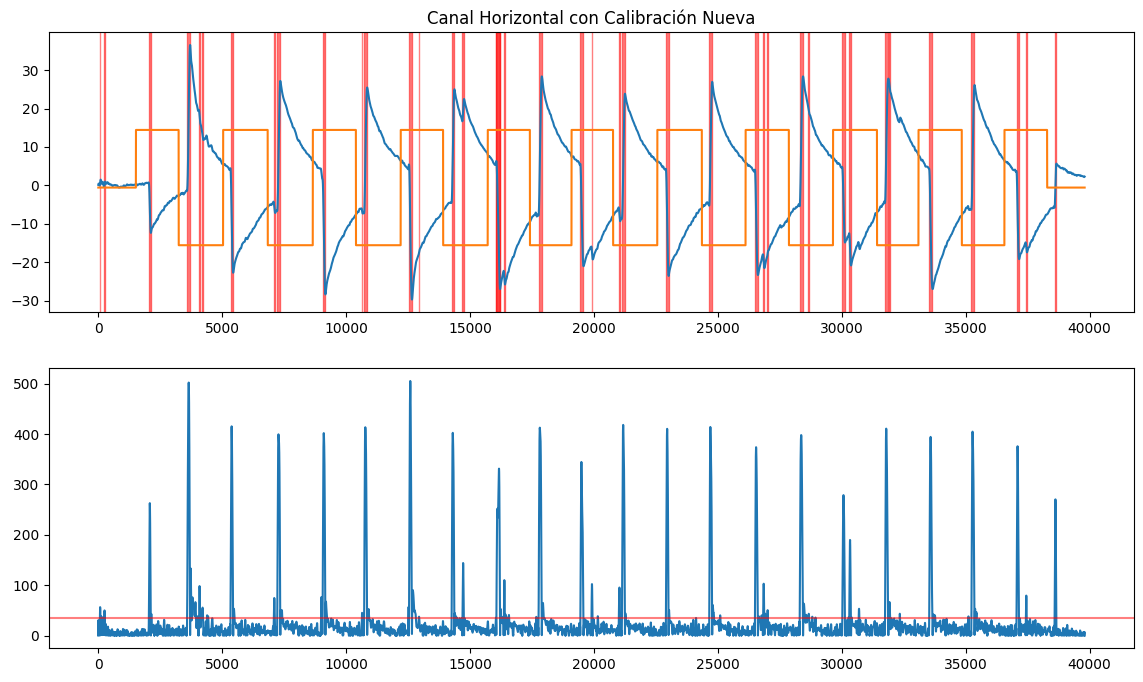

In [41]:
# Vamos a operar esta vez con la señal cruda para utilizar toda la información
# posible y controlar mejor el efecto de los algoritmos
hori_channel = antisaccadic.hor_channel_raw
stim_channel = antisaccadic.hor_stimuli_raw

# Antes que nada vamos a quitar las primeras y las últimas muestras
# Con esto evitamos problemas con el escalado
SAMPLES_TO_CUT = 100
cutted_hori_channel = hori_channel[SAMPLES_TO_CUT:-SAMPLES_TO_CUT]
cutted_stim_channel = stim_channel[SAMPLES_TO_CUT:-SAMPLES_TO_CUT]
time_channel = np.arange(len(cutted_hori_channel))

# Escalamos a los grados de la prueba antisacádica
scaled_hori_channel = scale_channel(cutted_hori_channel, antisaccadic.angle)
#scaled_stim_channel = scale_channel(cutted_stim_channel, antisaccadic.angle)
scaled_stim_channel = scale_stimuli(cutted_stim_channel, antisaccadic.angle)

# Centramos las 2 señales para que esten en el mismo espacio angular
centered_hori_channel = center_signal(scaled_hori_channel)
centered_stim_channel = center_signal(scaled_stim_channel)

# Eliminación de ruido de la señal horizontal
denoised_hori_channel = denoise_35(scaled_hori_channel)

# Centro la señal horizontal sin ruido
centered_denoised_hori_channel = center_signal(denoised_hori_channel)

# Cálculo del perfil de velocidad
vel_channel = differentiate(centered_denoised_hori_channel)
abs_vel_channel = abs(vel_channel)

# Encontrar picos utilizando la Transformada Contínua de Wavelet (CWT)
peaks = signal.find_peaks_cwt(abs_vel_channel, 30)

VELOCITY_THRESHOLD = 35
DURATION_THRESHOLD = 15

impulses_list = [
    (onset, offset)
    for onset, offset in impulses(
        channel=abs_vel_channel,
        peaks=peaks,
        velocity_threshold=VELOCITY_THRESHOLD,
        duration_threshold=DURATION_THRESHOLD,
    )
]

classified_impulses = []
for idx, (onset, offset, direction, size, duration, amplitude) in enumerate(clasify_impulses(denoised_hori_channel, impulses_list)):
    classified_impulses.append((onset, offset, direction, size, duration, amplitude))
    print(f"#{idx + 1:02} -", onset, offset, direction.name, size.name, duration, amplitude)

# Plotear
PLOT_START, PLOT_END = 0, time_channel[-1]
#PLOT_START, PLOT_END = 6000, 10000

#plt.subplot(211)
#plt.title("Canal Horizontal con Calibración Previa")
#plt.plot(time_channel[PLOT_START:PLOT_END], antisaccadic.hor_stimuli[SAMPLES_TO_CUT:-SAMPLES_TO_CUT][PLOT_START:PLOT_END])
#plt.plot(time_channel[PLOT_START:PLOT_END], antisaccadic.hor_channel[SAMPLES_TO_CUT:-SAMPLES_TO_CUT][PLOT_START:PLOT_END])

plt.subplot(211)
plt.title("Canal Horizontal con Calibración Nueva")
plt.plot(time_channel[PLOT_START:PLOT_END], centered_denoised_hori_channel[PLOT_START:PLOT_END])
plt.plot(time_channel[PLOT_START:PLOT_END], centered_stim_channel[PLOT_START:PLOT_END])
for onset, offset in impulses_list:
    if offset < PLOT_START:
        continue

    if onset > PLOT_END:
        continue
        
    plt.axvspan(onset, offset, color='red', alpha=0.5)

plt.subplot(212)
plt.plot(time_channel[PLOT_START:PLOT_END], abs_vel_channel[PLOT_START:PLOT_END])
plt.axhline(VELOCITY_THRESHOLD, color='red', alpha=0.5)


# Implementación dataclass

In [42]:
@dataclass
class AntissaccadeBiomarkers:
    latency: float
    location_memory: float
    peak_velocity: float
    duration: float
    correction_latency: float

@dataclass
class AntissaccadicBiomarkers:
    antisaccades: list[AntissaccadeBiomarkers]
    latency_mean: float
    latency_std: float
    location_memory_mean: float
    location_memory_std: float
    peak_velocity_mean: float
    peak_velocity_std: float
    duration_mean: float
    duration_std: float
    correction_latency_mean: float
    correction_latency_std: float
    response_inhibition: float

class Direction(Enum):
    Left = "left"
    Right = "right"

NameError: name 'dataclass' is not defined

In [ ]:
def antissacadic_biomarkers(channel: np.ndarray, stimuli: np.ndarray) -> AntissaccadicBiomarkers:
    antisaccades_movements = antisaccades(channel, stimuli)
    saccades_movements = saccades(channel, stimuli, antisaccades_movements)

    latencies = antisaccade_latencies_biomarker(stimuli, antisaccades_movements)
    inhibition = antisaccade_response_inhibition_biomarker(saccades_movements, antisaccades_movements)
    location_memory = antisaccade_location_memory_biomarker(channel, stimuli, antisaccades_movements)
    velocities = antisaccade_velocities_biomarker(channel, antisaccades_movements)
    durations = antisaccade_durations_biomarker(antisaccades_movements)
    correction_latencies = antisaccade_correction_latencies_biomarker(saccades_movements, antisaccades_movements)
